# Data Understanding

This notebook is a proof-of-concept on finding out the exact specifications of the data that we wish to operate on. This step has several goals:
- Find out the data specification
- Find the best data representation for our deep learning model
- ???.

## Constants

| Constants            | Value |
|----------------------|---     |
| Sample rate          | 8000 |
| Image height         | 500|
| Image width (window) | 157   |
| Window length        | SAMPLE_RATE * 10 |

In [59]:
import os
import sys
sys.path.append('../script')
import constants

# CONSTANTS
DATASET_DIR = '../dataset'
SAMPLE_RATE = 8000 # 8 kHz sample rate; we downsampled because we want 4KHz — making the model more robust against noise in the higher frequencies.
IMAGE_HEIGHT = 500
IMAGE_WIDTH = 157
SPLIT_SECOND = 10 # second
WAVE_SAMPLE_LENGTH = int(SAMPLE_RATE * 0.25)
SAMPLE_LENGTH = SAMPLE_RATE * 10

## Dialects

Per the dialects retrieved from Max Planck Institute's EVA Jakarta Field Station, we have these dialects:
- Ngadas
- Banten
- Tengger
- Semarang
- Madiun
- Tegal
- Banyumas
- Papua
- Lumajang
- Solo
- Pemalang
- Cirebon
- Kediri
- Malang
- Osing
- Ranu Pane

In [2]:
dialects = os.listdir(constants.RAW_DIR)
dialects

['Ngadas',
 'Banten',
 'Tengger',
 'Semarang',
 'Madiun',
 'Tegal',
 'Banyumas',
 'Papua',
 'Lumajang',
 'Solo',
 'Pemalang',
 'Cirebon',
 'Kediri',
 'Malang',
 'Osing',
 'Ranu Pane']

## Audio Loading

In [3]:
wavs = dict()

for dialect in dialects:
    wavs[dialect] = [wav for wav in os.listdir(constants.RAW_DIR + dialect) if wav[-3:] == 'wav']

wavs

{'Ngadas': ['Marsam.wav', 'Mas_Tom_Ngadas_201102.wav'],
 'Banten': ['JWBP-20121229-A.wav',
  'JWBA-20100703-a.wav',
  'JWB-Banten_9.wav',
  'banten-2010-07-02-a.wav',
  'JWB-20090125.wav',
  'JWBP-20121229-B.wav',
  'JWB-Banten_10.wav',
  'JWB-20090126.wav',
  'JWB-20090116.wav',
  'JWB-Banten20100605-B.wav',
  'JWB-Banten_1.wav',
  'JWB-Banten_6.wav',
  'JWBA-20100703-b.wav',
  'JWB-Banten_4.wav',
  'JWB-20090117.wav',
  'JWB-20090118.wav',
  'JWB-Banten_8.wav',
  'JWB-20090131.wav',
  'JWB-20090130.wav',
  'JWB-Banten_11.wav',
  'JWB-Banten_5.wav',
  'JWB-20090123.wav',
  'JWB-20090124.wav',
  'JWB-20090127.wav',
  'JWB-Banten_19.wav',
  'JWB-Banten20100605-A.wav',
  'JWB-Banten_7.wav',
  'JWB-Banten_3.wav',
  'JWB-Banten_2.wav',
  'JWB-20090120.wav',
  'JWB-20090122.wav',
  'JWB-20070129.wav',
  'JWBS-20100702-b.wav'],
 'Tengger': ['Ngadisari.wav', 'Wonokitri.wav'],
 'Semarang': ['JCM-20080114.wav', 'JCM-20080115.wav'],
 'Madiun': ['Madiun.wav',
  'Madiun-20080125-Marpuah.wav',
  'J

In [4]:
# Loading our example audio
import librosa

_ = librosa.load(
    "../dataset/raw/Banten/JWB-20090117.wav",
    sr=SAMPLE_RATE,
    mono=True
)[0]

In [5]:
_

array([0.        , 0.        , 0.        , ..., 0.07184704, 0.08652782,
       0.        ], dtype=float32)

## Waveform

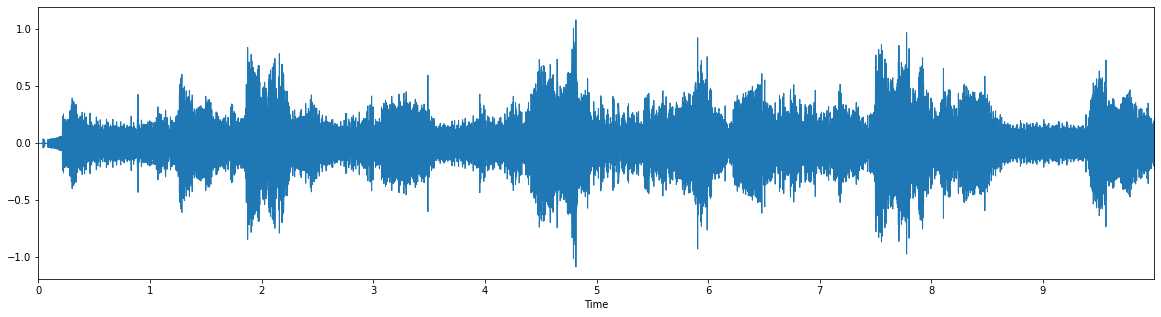

In [6]:
from matplotlib import pyplot as plt
from librosa import display

plt.figure(figsize=(20,5))
display.waveplot(_[:SAMPLE_LENGTH], sr=SAMPLE_RATE)

plt.show()

In [7]:
# Audio splitting: .25 seconds
_segment = _[:SAMPLE_LENGTH]

In [8]:
_segment

array([0.        , 0.        , 0.        , ..., 0.22255474, 0.22708367,
       0.2257466 ], dtype=float32)

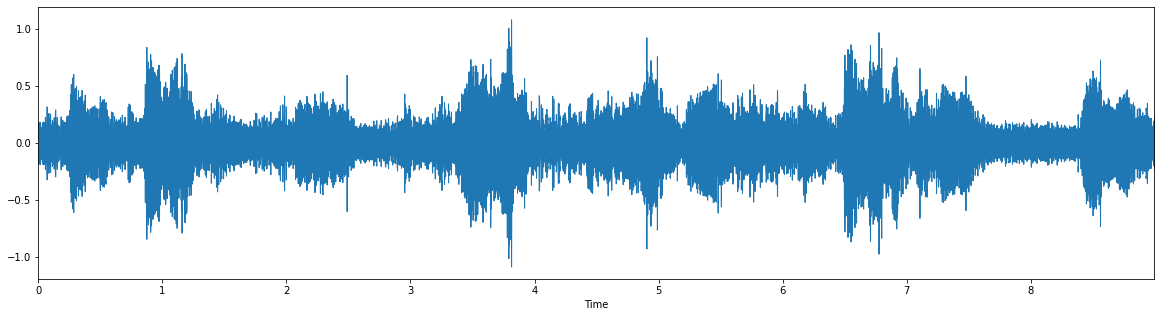

In [9]:
# Audio sample visualization
from matplotlib import pyplot as plt
from librosa import display

plt.figure(figsize=(20,5))
librosa.display.waveplot(_segment[SAMPLE_RATE:], sr=SAMPLE_RATE)
plt.show()

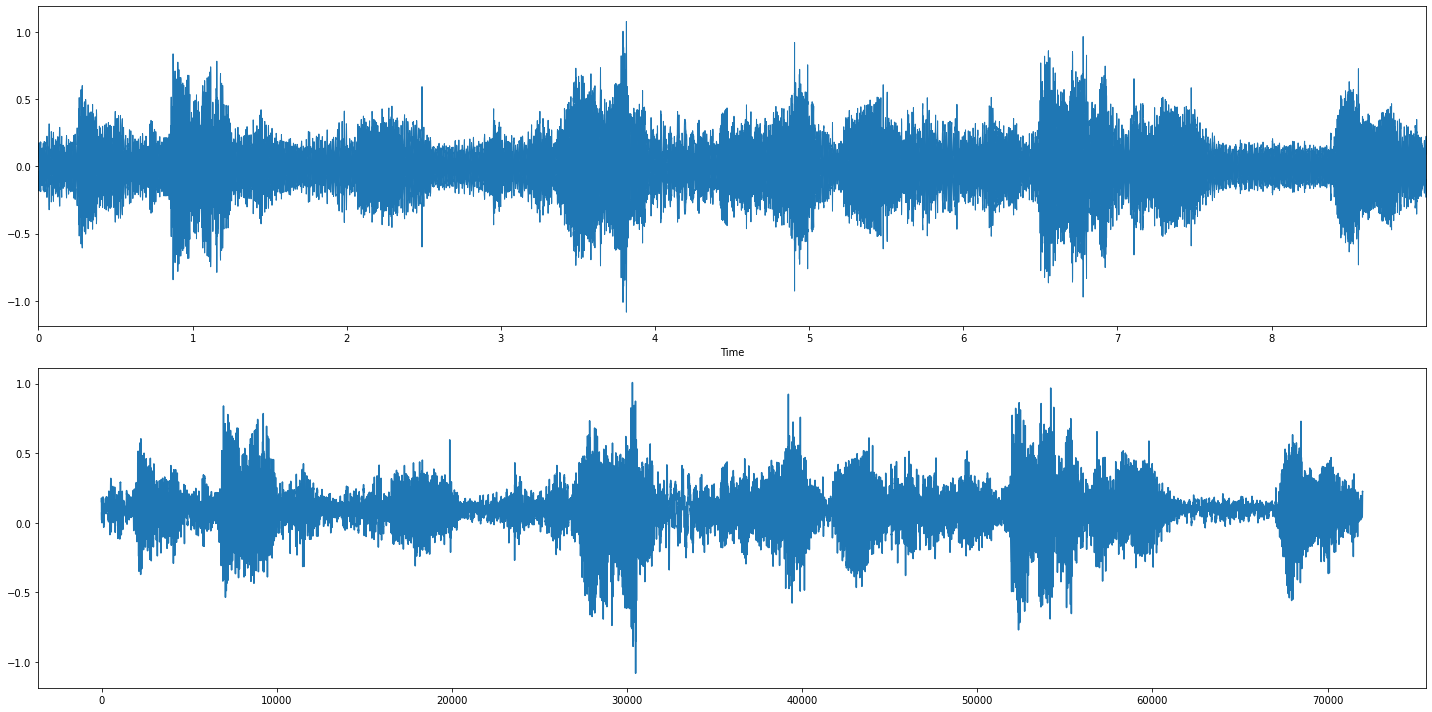

In [10]:
# Waveplot and plot side-by-side illustration
fig, ax = plt.subplots(2, figsize=(20, 10))
librosa.display.waveplot(_segment[SAMPLE_RATE:], sr=SAMPLE_RATE, ax=ax[0])
ax[1].plot(_segment[SAMPLE_RATE:])

plt.tight_layout()
plt.savefig('../visualization/plot_vs_wave.png', pad_inches=0)
plt.show()

## Spectrograms
Designed as a <> , spectrogram represents <> of an audio file with respect to <> and <>. There are multiple types of spectrograms that we can get from an audio file: Mel spectrogram and Frequency spectrogram.

### Mel Spectrogram

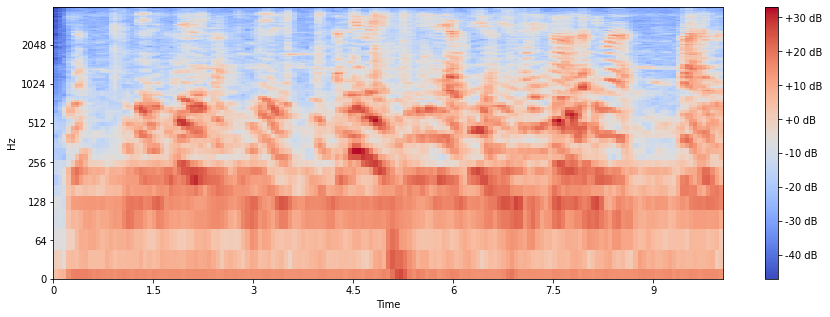

In [11]:
# Audio Mel Spectrogram

# _spectrogram = librosa.feature.melspectrogram(_[0], sr=SAMPLE_RATE, hop_length=int(_[0].shape[0]))
_mel_spectrogram = librosa.feature.melspectrogram(_segment, sr=SAMPLE_RATE)
_mel_spectrogram_image = librosa.core.power_to_db(_mel_spectrogram)

plt.figure(figsize=(15, 5))
librosa.display.specshow(_mel_spectrogram_image, sr=SAMPLE_RATE, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.savefig('../visualization/mel_spec.png')
plt.show()

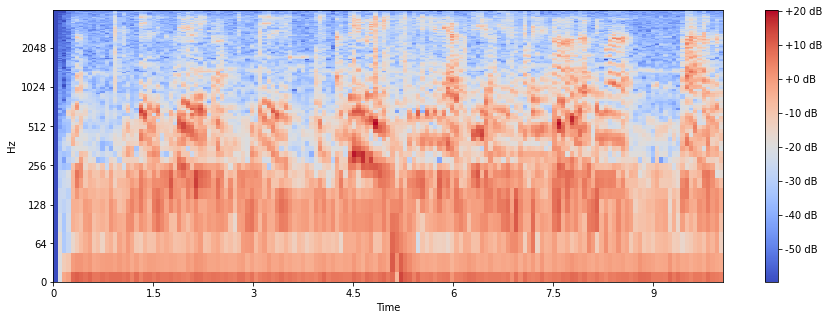

In [12]:
_mel_spectrogram = librosa.feature.melspectrogram(_segment, sr=SAMPLE_RATE, n_fft=400)
_mel_spectrogram_image = librosa.core.power_to_db(_mel_spectrogram)

plt.figure(figsize=(15, 5))
librosa.display.specshow(_mel_spectrogram_image, sr=SAMPLE_RATE, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.savefig('../visualization/mel_spec_fft400')
plt.show()

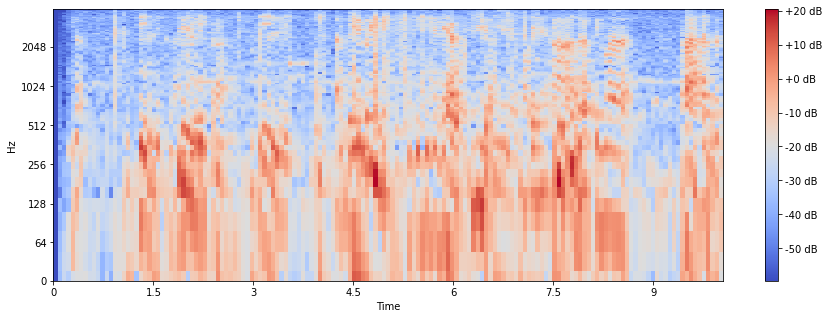

In [13]:
_mel_spectrogram = librosa.feature.melspectrogram(_segment, sr=SAMPLE_RATE, n_fft=400, fmin=200, fmax=4000)
_mel_spectrogram_image = librosa.core.power_to_db(_mel_spectrogram)

plt.figure(figsize=(15, 5))
librosa.display.specshow(_mel_spectrogram_image, sr=SAMPLE_RATE, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')

plt.savefig('../visualization/mel_spec_fft400_200-4000hz.png')
plt.show()

In [14]:
_mel_spectrogram.shape

(128, 157)

### Frequency Spectrogram

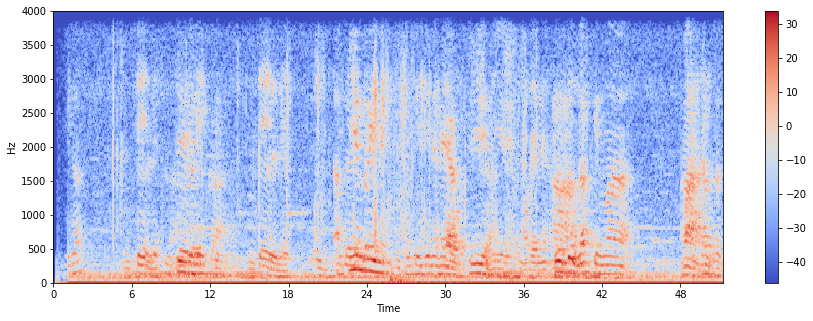

In [43]:
# Spectrogram
_spectrogram = librosa.core.stft(_segment, n_fft=400)
_spectrogram_db = librosa.amplitude_to_db(abs(_spectrogram))

plt.figure(figsize=(15, 5))
librosa.display.specshow(_spectrogram_db, sr=SAMPLE_RATE, x_axis='time', y_axis='hz')
plt.colorbar()

plt.savefig('../visualization/spec.png')
plt.show()

In [16]:
_spectrogram.shape

(201, 801)

### Spectrogram (log-adjusted)

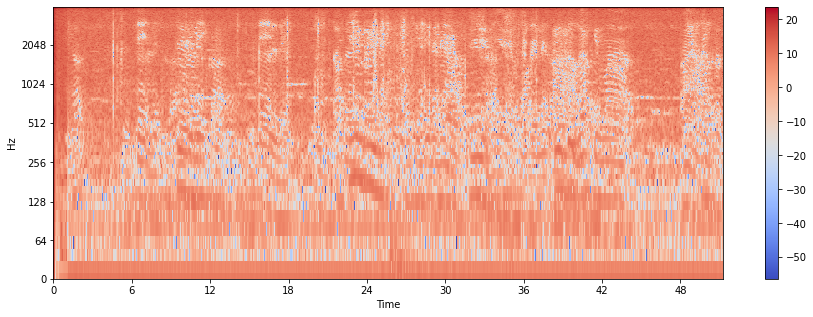

In [46]:
# Spectrogram - log-adjusted
import cupy as cp
import numpy as np

# _spectrogram_log_db = cp.log(cp.abs(cp.asarray(_spectrogram)))
_spectrogram_log_db = librosa.amplitude_to_db(cp.log(cp.abs(cp.asarray(_spectrogram))).get())

plt.figure(figsize=(15, 5))
librosa.display.specshow(_spectrogram_log_db, sr=SAMPLE_RATE, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()

### Comparison

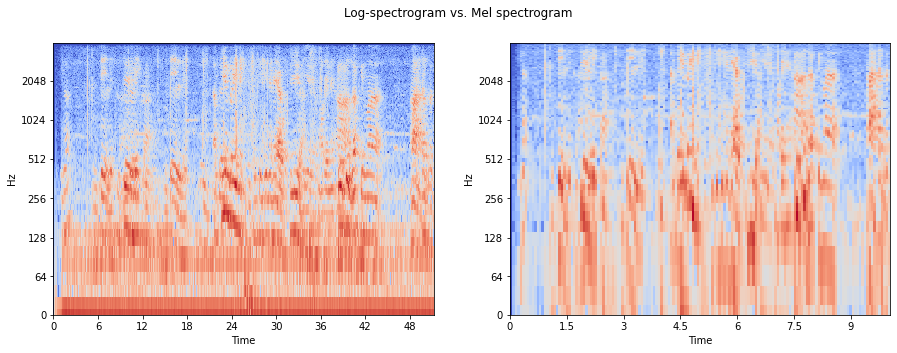

In [18]:
# Log spectrogram vs. Mel spectrogram
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Log-spectrogram vs. Mel spectrogram')
librosa.display.specshow(_spectrogram_db, sr=SAMPLE_RATE, x_axis='time', y_axis='log', ax=ax[0])
librosa.display.specshow(_mel_spectrogram_image, sr=SAMPLE_RATE, x_axis='time', y_axis='log', ax=ax[1])

plt.show()

## Mel Frequency Cepstrum Coefficient

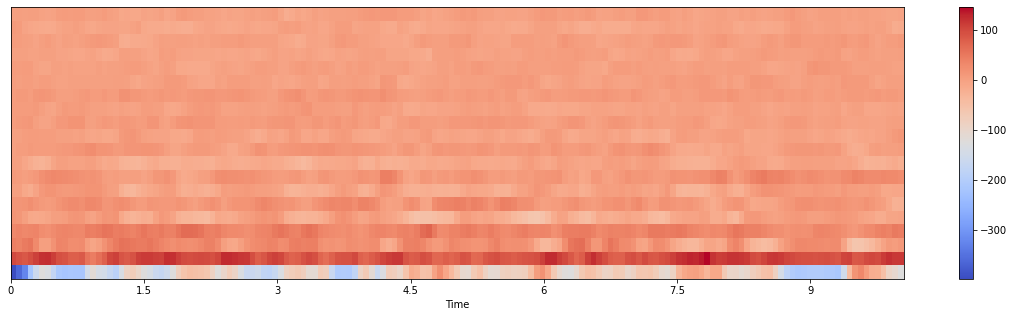

In [19]:
_mfcc = librosa.feature.mfcc(_segment, sr=SAMPLE_RATE)

plt.figure(figsize=(20, 5))
librosa.display.specshow(_mfcc, sr=SAMPLE_RATE, x_axis='time')
plt.colorbar()

plt.savefig('../visualization/mfcc.png')
plt.show()

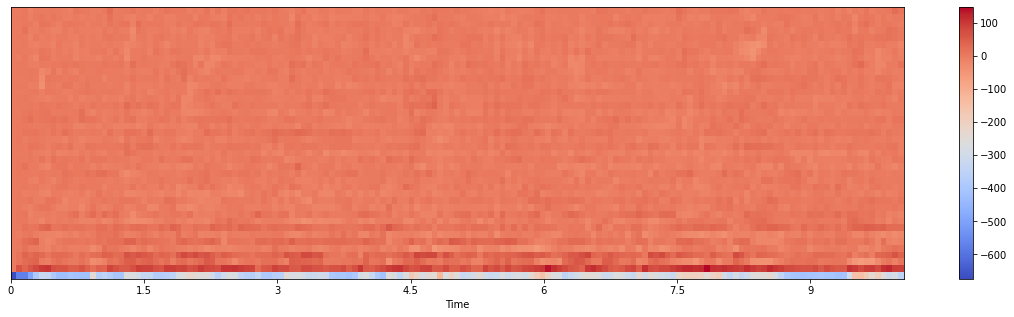

In [20]:
_mfcc = librosa.feature.mfcc(_segment, sr=SAMPLE_RATE, n_fft=400, n_mfcc=40, fmin=200, fmax=4000)

plt.figure(figsize=(20, 5))
librosa.display.specshow(_mfcc, sr=SAMPLE_RATE, x_axis='time')
plt.colorbar()

plt.savefig('../visualization/mfcc_shon2018.png')
plt.show()

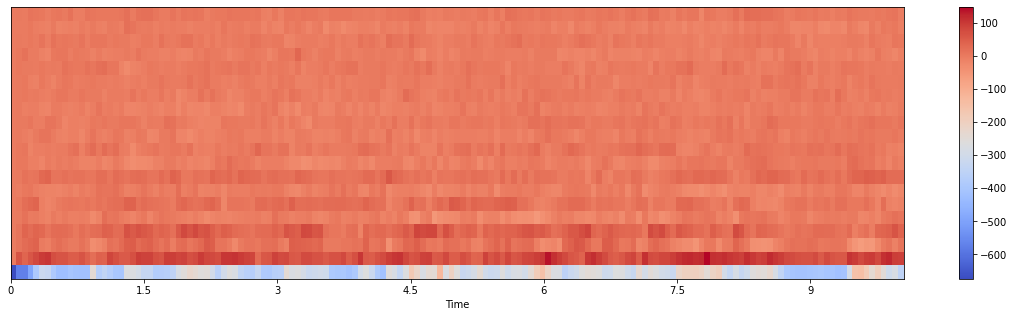

In [21]:
# MFCC from Mel spectrogram

_mfcc_from_mel_spectrogram = librosa.feature.mfcc(S=_mel_spectrogram_image)

plt.figure(figsize=(20, 5))
librosa.display.specshow(_mfcc_from_mel_spectrogram, sr=SAMPLE_RATE, x_axis='time')
plt.colorbar()

plt.savefig('../visualization/mfcc_from_spectrogram.png')
plt.show()

## Voice Activity Detection

In [22]:
# Voice Activity Detection - courtesy of Shon et al., (2018)
import numpy as np

_rmse = librosa.feature.rms(_segment, frame_length=400, hop_length=_segment.shape[0] // IMAGE_WIDTH)
threshold = np.mean(_rmse) / 2 * 1.04
vad_segments = np.nonzero(_rmse > threshold)

In [23]:
print(_rmse)

[[4.42031451e-05 1.84932984e-02 3.38143855e-02 6.21848144e-02
  1.28892168e-01 1.73700973e-01 1.35996193e-01 1.29150242e-01
  1.28891781e-01 1.19420506e-01 1.12680726e-01 1.10975869e-01
  1.07664421e-01 1.19828574e-01 1.05445035e-01 1.12120524e-01
  1.12305939e-01 1.33309409e-01 1.35072470e-01 1.20701358e-01
  2.22879827e-01 1.93643883e-01 1.32687598e-01 1.58784688e-01
  1.77735478e-01 1.20232932e-01 1.18617252e-01 1.54500440e-01
  1.21128075e-01 1.71498731e-01 2.92045295e-01 2.39289373e-01
  2.26793781e-01 3.01639706e-01 2.60965556e-01 1.80245757e-01
  1.32852197e-01 1.37146667e-01 1.56863183e-01 1.31179169e-01
  1.16289496e-01 1.05245836e-01 1.06259830e-01 1.08609393e-01
  1.20079875e-01 1.17480814e-01 1.41503721e-01 1.48240745e-01
  1.14357002e-01 1.41707659e-01 1.54996693e-01 1.63986579e-01
  1.74517319e-01 1.64525703e-01 1.48212314e-01 1.27509370e-01
  1.01389989e-01 9.66353267e-02 1.06492482e-01 9.64075625e-02
  1.10574119e-01 1.00997098e-01 1.34142205e-01 1.26366556e-01
  1.0892

In [24]:
print(_rmse > threshold)

[[False False False False  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True]]


In [62]:
# Another example - high gain
_hg = librosa.load(
    '../dataset/raw/Ngadas/Marsam.wav',
    sr=SAMPLE_RATE,
    # mono=True,
    res_type='soxr_vhq'
)[0]

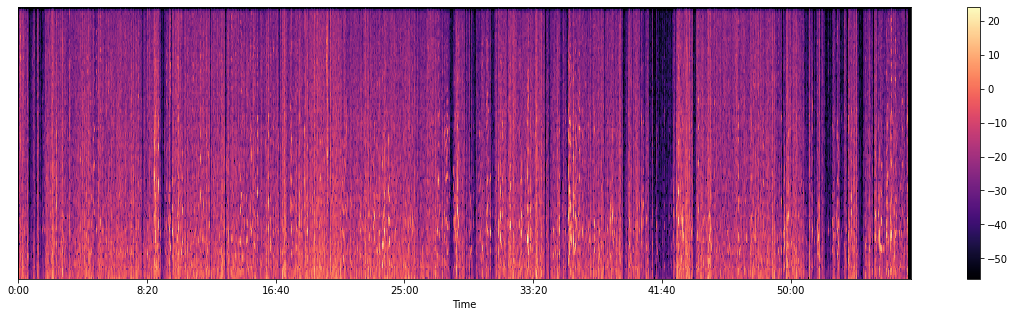

In [63]:
# Using Mel spectrogram.
_hg_mel_spec = librosa.feature.melspectrogram(_hg, sr=SAMPLE_RATE, n_fft=400, fmin=200, fmax=4000)

plt.figure(figsize=(20, 5))
_hg_mel_spec_image = librosa.core.power_to_db(_hg_mel_spec)
librosa.display.specshow(_hg_mel_spec_image, sr=SAMPLE_RATE, x_axis='time')

plt.colorbar()
plt.savefig('../visualization/mel_spectrogram_full.png')
plt.show()

In [28]:
_hg_mel_spec.shape

(128, 3377)

In [29]:
_hg_rms = librosa.feature.rms(_hg, frame_length=400)
_hg_threshold = np.mean(_hg_rms) / 2 * 1.04
_hg_mask = np.nonzero(_hg_rms > _hg_threshold)[1]

print('Mask percentage: {a:2d}%'.format(a = int(_hg_mask.shape[0]/_hg_mel_spec.shape[1]*100)))

Mask percentage: 85%


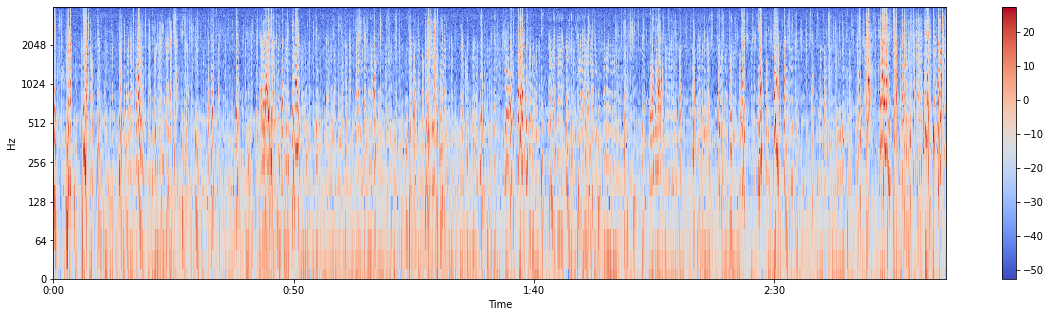

In [30]:
_hg_mel_spec_vad = _hg_mel_spec[:, _hg_mask]

plt.figure(figsize=(20,5))
librosa.display.specshow(librosa.core.power_to_db(_hg_mel_spec_vad), sr=SAMPLE_RATE, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()

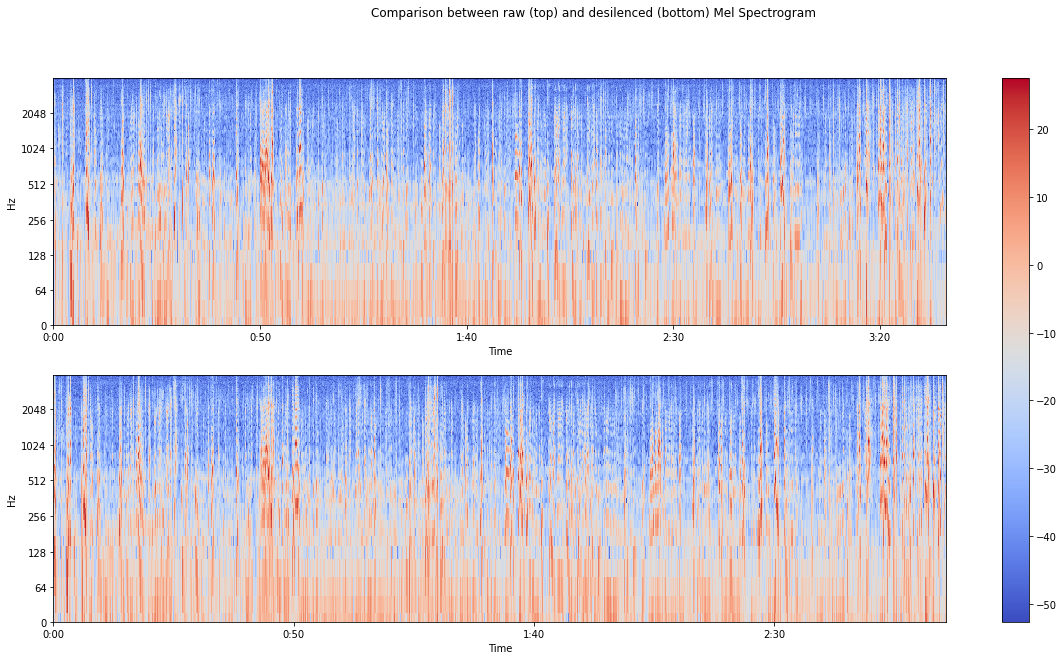

In [31]:
# Comparison

fig, ax = plt.subplots(2, figsize=(20, 10))
fig.suptitle('Comparison between raw (top) and desilenced (bottom) Mel Spectrogram')
librosa.display.specshow(librosa.core.power_to_db(_hg_mel_spec), sr=SAMPLE_RATE, x_axis='time', y_axis='log', ax=ax[0])
smth = librosa.display.specshow(librosa.core.power_to_db(_hg_mel_spec_vad), sr=SAMPLE_RATE, x_axis='time', y_axis='log', ax=ax[1])
fig.colorbar(smth, ax=ax)
plt.show()

### Functions

In [40]:
# Windowing and Gating

# def filter_noise(wave):
#     _rms = librosa.feature.rms(wave, frame_length=400, hop_length=wave.shape[0] // IMAGE_WIDTH)
#     _threshold = np.mean(_rms) / 2 * 1.04
#     _mask = np.nonzero(_rms > _threshold)[1]
#     return wave[:, _mask]

def split_second(wave, second=10, sr=SAMPLE_RATE):
    wave_windows = list()
    l = 0
    r = second * sr
    while r < wave.shape[0]:
        wave_windows.append(wave[l:r])
        print(l, r, r/sr)
        l += second * sr
        r = r + second * sr if r + second * sr < wave.shape[0] else wave.shape[0]
    wave_windows.append(wave[l:r])
    print('Done at', l, r)
    return wave_windows

def desilence(wave, feature):
    _rms = librosa.feature.rms(wave, frame_length=400)
    _threshold = np.mean(_rms) / 2 * 1.04
    _mask = np.nonzero(_rms > _threshold)[1]

    return feature[:, _mask]

In [33]:
_split = split_second(_)

0 80000 10.0
80000 160000 20.0
160000 240000 30.0
240000 320000 40.0
320000 400000 50.0
400000 480000 60.0
480000 560000 70.0
560000 640000 80.0
640000 720000 90.0
720000 800000 100.0
800000 880000 110.0
880000 960000 120.0
960000 1040000 130.0
1040000 1120000 140.0
1120000 1200000 150.0
1200000 1280000 160.0
1280000 1360000 170.0
1360000 1440000 180.0
1440000 1520000 190.0
1520000 1600000 200.0
1600000 1680000 210.0
1680000 1760000 220.0
1760000 1840000 230.0
1840000 1920000 240.0
1920000 2000000 250.0
2000000 2080000 260.0
2080000 2160000 270.0
2160000 2240000 280.0
2240000 2320000 290.0
2320000 2400000 300.0
2400000 2480000 310.0
2480000 2560000 320.0
2560000 2640000 330.0
2640000 2720000 340.0
2720000 2800000 350.0
2800000 2880000 360.0
2880000 2960000 370.0
2960000 3040000 380.0
3040000 3120000 390.0
3120000 3200000 400.0
3200000 3280000 410.0
3280000 3360000 420.0
3360000 3440000 430.0
3440000 3520000 440.0
3520000 3600000 450.0
3600000 3680000 460.0
3680000 3760000 470.0
3760000

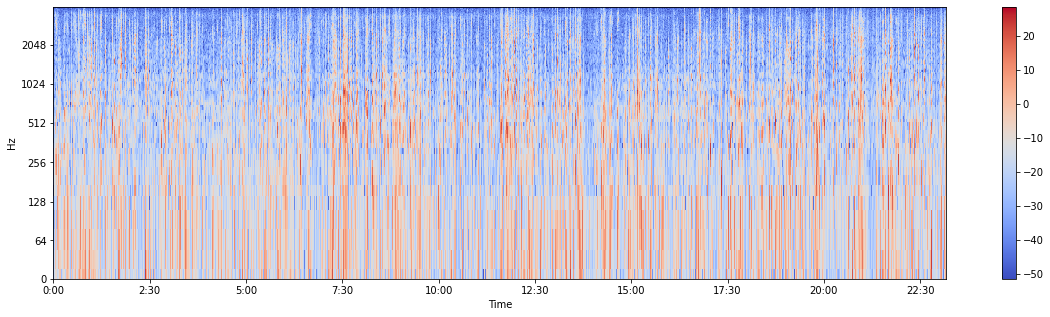

In [34]:
_mel_spectrogram = librosa.feature.melspectrogram(_, sr=SAMPLE_RATE, n_fft=400, fmin=200, fmax=4000)

plt.figure(figsize=(20, 5))
librosa.display.specshow(librosa.core.power_to_db(_mel_spectrogram), sr=SAMPLE_RATE, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()

In [35]:
_mel_spectrogram.shape

(128, 21729)

In [36]:
_desilenced = get_vad_mask(_, _mel_spectrogram)
_desilenced.shape

(128, 20903)

In [37]:
_mel_spectrogram.shape

(128, 21729)

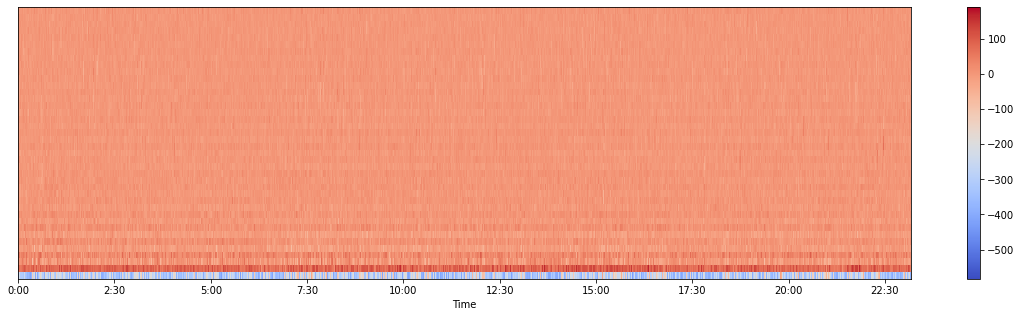

In [38]:
# MFCC - Full
_mfcc = librosa.feature.mfcc(_, sr=SAMPLE_RATE, n_mfcc=40, n_fft=400, fmin=200, fmax=4000)

plt.figure(figsize=(20, 5))
librosa.display.specshow(_mfcc, sr=SAMPLE_RATE, x_axis='time')

plt.colorbar()
plt.show()

In [39]:
_mfcc.shape

(40, 21729)

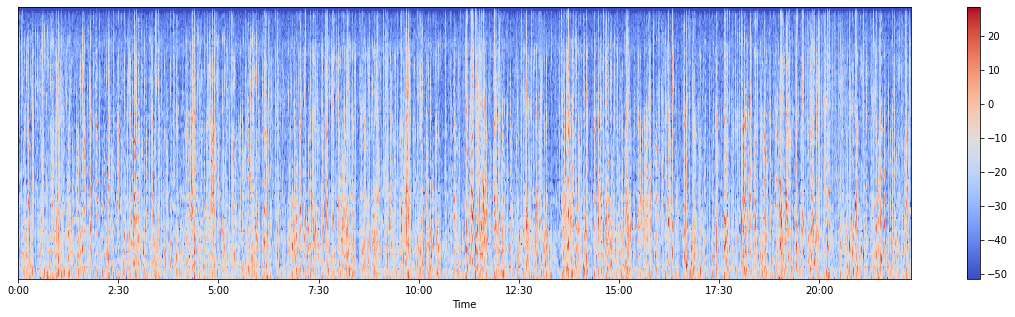

In [42]:
# Voice Activity Detection on full WAV
_mel_spectrogram_desilenced = desilence(_, _mel_spectrogram)

plt.figure(figsize=(20, 5))
librosa.display.specshow(librosa.core.power_to_db(_mel_spectrogram_desilenced), sr=SAMPLE_RATE, x_axis='time')

plt.colorbar()
plt.show()